# Classification
This file includes code which classifies text chunks as (Austen, Shelly, Kafka, Tolstoy or Dostoyevsky).
The training data is text chunks from their respective works _Pride and predjudice_, _Frankenstein_, _The trial_, _Anna Karenina_ and _Crime and punishment_. We obtain the texts from the Gutenberg Project.

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import skorch
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from textdataset import TextDataset
from neural_net import NeuralNet

Training the model:

In [2]:
def training_model(dataloader, model, loss_fn, optimizer, num_epochs=100):
    for epoch in range(num_epochs):
        # setting the model to train mode
        model.train()
        
        for (X, y) in dataloader:
            pred = model(X)
            loss = loss_fn(pred, y)

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()           # resets the gradients

        if epoch % 1 == 0:
            loss = loss.item()
            print(f"Epoch {epoch+1:>4f}      loss: {loss:>7f}")

Test loop:

In [3]:
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode 
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    all_preds = []
    all_labels = []

    with torch.no_grad():           # gradient computation excluded, unnecessary
        for X, y in dataloader:
            pred = model(X)

            all_preds.extend(pred.argmax(1).tolist())
            all_labels.extend(y.tolist())

            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        test_loss /= num_batches
        correct /= size
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return all_preds, all_labels, correct

In [2]:
net = skorch.NeuralNetClassifier(
    NeuralNet,
    max_epochs=50,
    iterator_train__shuffle=True,
    optimizer=torch.optim.Adam
)

In [3]:
X = np.load('text_data_sentences.npy')
y = np.load('labels_sentences.npy')

### Gridsearch for optimal learning rate

In [ ]:
# splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=3)

y_train = torch.from_numpy(y_train).long()
y_test = torch.from_numpy(y_test).long()

dataset_train = TextDataset(torch.tensor(X_train), y_train)
dataset_test = TextDataset(torch.tensor(X_test), y_test)

# splitting the data into batches
batch_size = 64
torch.manual_seed(1)
dl_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
dl_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, drop_last=True)

param_grid = {
    'optimizer__lr': [0.0001, 0.001, 0.01]
}

grid = GridSearchCV(estimator=net, param_grid=param_grid, n_jobs=1, cv=5)
grid_result = grid.fit(X_train, y_train)

print(grid_result.cv_results_['mean_test_score'])

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.4173       0.8700        1.2153  0.2620
      2        1.0638       0.8781        0.9274  0.2334
      3        0.8251       0.8975        0.7360  0.2850
      4        0.6666       0.8969        0.6084  0.2539
      5        0.5582       0.8962        0.5204  0.2434
      6        0.4805       0.9069        0.4543  0.2505
      7        0.4232       0.9094        0.4063  0.2496
      8        0.3801       0.9100        0.3690  0.2503
      9        0.3462       0.9087        0.3408  0.2535
     10        0.3195       0.9119        0.3182  0.2439
     11        0.2980       0.9137        0.2992  0.2165
     12        0.2794       0.9131        0.2841  0.2335
     13        0.2640       0.9169        0.2714  0.2538
     14        0.2512       0.9181        0.2605  0.2458
     15        0.2396       0.9187        0.2501  0.2333
     16        0.2297       0.9

In [5]:
means = grid_result.cv_results_['mean_test_score']
means

array([0.937 , 0.9379, 0.9401])

Accuracy: [0.9937, 0.9379, 0.9401]

### Accuracy as a function of Dataset size

In [6]:
numbers = np.arange(5, 101, 5)
accuracy = np.zeros(len(numbers))

X = np.load('text_data_sentences.npy')
y = np.load('labels_sentences.npy')

# splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=3)

y_train = torch.from_numpy(y_train).long()
y_test = torch.from_numpy(y_test).long()

dataset_train = TextDataset(torch.tensor(X_train), y_train)
dataset_test = TextDataset(torch.tensor(X_test), y_test)

# splitting the data into batches
batch_size = 64
torch.manual_seed(1)
dl_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
dl_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, drop_last=True)

# defining the model, optimizer and loss function
model = NeuralNet()

learning_rate = 0.01
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

net.fit(X_train, y_train)

indices = int(X_train.shape[0]/10) * numbers

for idx, per in enumerate(indices):
    accuracy[idx] = np.mean(cross_val_score(net, X_train[:per], y_train[:per], scoring='accuracy', cv=10))

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.3501       0.9080        0.2616  0.3109
      2        0.1604       0.9270        0.2152  0.3504
      3        0.1187       0.9260        0.2007  0.3670
      4        0.0915       0.9190        0.2468  0.3831
      5        0.0713       0.9380        0.2151  0.3494
      6        0.0482       0.9295        0.2328  0.3208
      7        0.0346       0.9345        0.2417  0.3459
      8        0.0182       0.9380        0.2640  0.3424
      9        0.0090       0.9360        0.2652  0.3443
     10        0.0045       0.9385        0.2811  0.3315
     11        0.0026       0.9400        0.2885  0.3577
     12        0.0019       0.9375        0.2956  0.3218
     13        0.0015       0.9385        0.2989  0.3086
     14        0.0013       0.9385        0.3058  0.3251
     15        0.0011       0.9385        0.3096  0.3831
     16        0.0009       0.9

In [7]:
accuracy

array([0.9268, 0.9423, 0.9421, 0.9425, 0.9421, 0.9413, 0.9416, 0.9416,
       0.9406, 0.9412, 0.9417, 0.9435, 0.9428, 0.9418, 0.9419, 0.9419,
       0.9421, 0.9409, 0.9424, 0.9417])

In [10]:
np.save('Data/results_accuracy_sentence.npy', accuracy)

### Accuraccy as a function of Chunk Size and Dataset Size

In [3]:
chunk_sizes = ['50', '100', '150']
numbers = np.arange(5, 101, 5)
accuracy = np.zeros((len(chunk_sizes), len(numbers)))

for idx, chunk in enumerate(chunk_sizes):

    X = np.load('text_data' + chunk + '.npy')
    y = np.load('labels' + chunk + '.npy')

    # splitting into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=3)

    y_train = torch.from_numpy(y_train).long()
    y_test = torch.from_numpy(y_test).long()

    dataset_train = TextDataset(torch.tensor(X_train), y_train)
    dataset_test = TextDataset(torch.tensor(X_test), y_test)

    # splitting the data into batches
    batch_size = 64
    torch.manual_seed(1)
    dl_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
    dl_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, drop_last=True)

    # defining the model, optimizer and loss function
    model = NeuralNet()

    learning_rate = 0.01
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    net.fit(X_train, y_train)

    indices = int(X_train.shape[0]/10) * numbers

    for idy, per in enumerate(indices):
        accuracy[idx, idy] = np.mean(cross_val_score(net, X_train[:per], y_train[:per], scoring='accuracy', cv=10))

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.2063       0.8768        0.8039  0.2270
      2        0.5865       0.9219        0.4444  0.2020
      3        0.3626       0.9307        0.3148  0.2000
      4        0.2722       0.9374        0.2558  0.1790
      5        0.2258       0.9462        0.2201  0.2030
      6        0.1977       0.9486        0.1985  0.1920
      7        0.1788       0.9514        0.1814  0.1800
      8        0.1645       0.9521        0.1697  0.1824
      9        0.1539       0.9532        0.1613  0.1820
     10        0.1454       0.9543        0.1534  0.1900
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.4125       0.7879        1.2091  0.1025
      2        1.0157       0.8638        0.8416  0.1370
      3        0.7109       0.9131        0.6097  0.0835
      4        0.5277       0.9

In [12]:
accuracy

array([0.9178, 0.9343, 0.9371, 0.9373, 0.9353, 0.9368, 0.9361, 0.9362,
       0.9356, 0.936 , 0.9361, 0.936 , 0.9369, 0.936 , 0.9362, 0.9366,
       0.9366, 0.9365, 0.9367, 0.935 ])

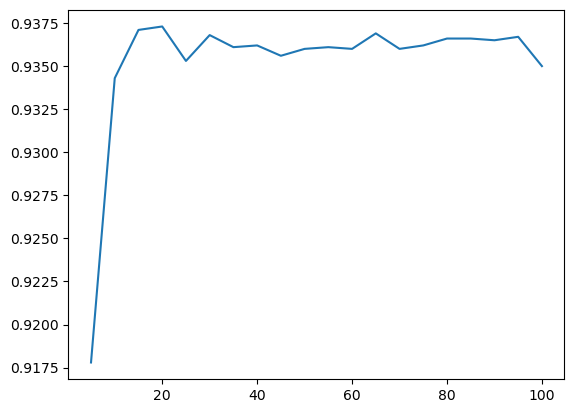

In [14]:
plt.plot(numbers, accuracy)

### Measuring performance on test dataset and creating confusion matrix

In [21]:
predictions, labels, acc = test_loop(dl_test, model, loss_fn)

# Compute and print confusion matrix
cm = confusion_matrix(labels, predictions)
print("Confusion Matrix:")
print(cm)

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.912660 

Confusion Matrix:
[[155   3   0   0   0]
 [  0 261   0   2   0]
 [  0   0 213   0   0]
 [  0   1   0 259   0]
 [  0   0   0   3 255]]


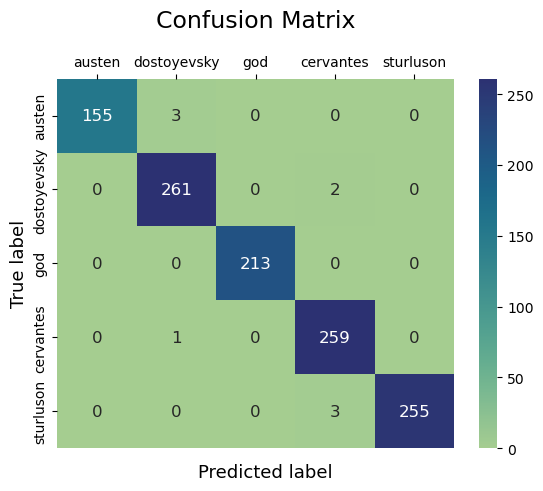

In [22]:
# Plotting the confusion matrix
ax = sns.heatmap(cm, 
            annot=True,
            annot_kws={"fontsize":12},
            fmt=".0f",
            xticklabels=['austen', 'dostoyevsky', 'god', 'cervantes', 'sturluson'],
            yticklabels=['austen', 'dostoyevsky', 'god', 'cervantes', 'sturluson'],
            cmap='crest')
plt.ylabel('True label', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20, loc='center')
ax.set(xlabel="", ylabel="True label")
ax.xaxis.tick_top()

plt.gca().figure.text(0.45, 0.05, 'Predicted label', ha='center', fontsize=13)
plt.show()

In [ ]:
indices = [int(X_train.shape[0]*(i/10)) for i in range(1, 11, 1)]
cvs = np.zeros(len(indices))

for idx, per in enumerate(indices):
    cvs[idx] = np.mean(cross_val_score(net, X_train[:per], y_train[:per], scoring='accuracy', cv=10))

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.6134       0.3059        1.5728  0.0250
      2        1.5699       0.4941        1.5340  0.0231
      3        1.5292       0.6706        1.4961  0.0101
      4        1.4888       0.7765        1.4587  0.0125
      5        1.4494       0.8000        1.4217  0.0146
      6        1.4092       0.8118        1.3835  0.0154
      7        1.3693       0.8118        1.3448  0.0136
      8        1.3282       0.8118        1.3053  0.0100
      9        1.2867       0.8118        1.2650  0.0090
     10        1.2439       0.8353        1.2244  0.0000
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.5979       0.4471        1.5431  0.0118
      2        1.5475       0.6941        1.4939  0.0125
      3        1.4987       0.8000        1.4469  0.0097
      4        1.4522       0.8

In [38]:
cvs

array([0.86484929, 0.94720045, 0.98028169, 0.98468393, 0.98858614,
       0.99084507, 0.98732028, 0.98573732, 0.98920188, 0.98986093])

In [ ]:
training_model(dataset_train, model, loss_fn, optimizer, num_epochs=1)

c:\Users\maria\anaconda3\envs\FYS-STK3155\Lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.904832


### Dimensionality Reduction

In [5]:
from sklearn.decomposition import PCA

In [28]:
num_comp = np.arange(1, 515, 3)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
batch_size = 64

num_comp = np.arange(6, 307, 3)
accuracy = np.zeros(len(num_comp))

for idx, n_comp in enumerate(num_comp):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=3)

    pca = PCA(n_components=n_comp)
    X_train = pca.fit_transform(X_train)

    y_train = torch.from_numpy(y_train).long()

    dataset_train = TextDataset(torch.tensor(X_train), y_train)

    torch.manual_seed(1)
    dl_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)

    net = skorch.NeuralNetClassifier(
        NeuralNet(input_dim=n_comp),
        max_epochs=50,
        learning_rate=0.01,
        loss_fn=nn.CrossEntropyLoss,
        iterator_train__shuffle=True,
        optimizer=torch.optim.Adam
    )

    net.fit(X_train, y_train)

    pred, label, acc =  test_loop(dl_train, model, loss_fn)

    accuracy[idx] = acc

c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 1.318808
Test Error: 
 Accuracy: 61.0%, Avg loss: 1.308682 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.941222
Test Error: 
 Accuracy: 96.7%, Avg loss: 0.947842 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.950853
Test Error: 
 Accuracy: 97.2%, Avg loss: 0.946163 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.951265
Test Error: 
 Accuracy: 97.3%, Avg loss: 0.947689 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.973511
Test Error: 
 Accuracy: 97.4%, Avg loss: 0.947616 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.958838
Test Error: 
 Accuracy: 97.6%, Avg loss: 0.952249 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.930914
Test Error: 
 Accuracy: 97.6%, Avg loss: 0.949569 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.953075
Test Error: 
 Accuracy: 97.8%, Avg loss: 0.949884 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.967154
Test Error: 
 Accuracy: 97.7%, Avg loss: 0.946938 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.958297
Test Error: 
 Accuracy: 97.8%, Avg loss: 0.950165 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.954820
Test Error: 
 Accuracy: 97.7%, Avg loss: 0.949808 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.973606
Test Error: 
 Accuracy: 97.6%, Avg loss: 0.953114 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.948335
Test Error: 
 Accuracy: 97.8%, Avg loss: 0.949878 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.933614
Test Error: 
 Accuracy: 97.9%, Avg loss: 0.950257 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.960209
Test Error: 
 Accuracy: 97.8%, Avg loss: 0.948206 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.967490
Test Error: 
 Accuracy: 97.9%, Avg loss: 0.950105 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.949310
Test Error: 
 Accuracy: 97.8%, Avg loss: 0.955625 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.967517
Test Error: 
 Accuracy: 97.8%, Avg loss: 0.950618 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.943847
Test Error: 
 Accuracy: 97.8%, Avg loss: 0.949321 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.959659
Test Error: 
 Accuracy: 97.8%, Avg loss: 0.951890 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.941838
Test Error: 
 Accuracy: 97.7%, Avg loss: 0.952249 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.945421
Test Error: 
 Accuracy: 97.7%, Avg loss: 0.951856 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.977415
Test Error: 
 Accuracy: 97.8%, Avg loss: 0.950581 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.952727
Test Error: 
 Accuracy: 97.9%, Avg loss: 0.952737 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.958564
Test Error: 
 Accuracy: 97.8%, Avg loss: 0.951732 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.945553
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.949306 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.955597
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.950983 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.954117
Test Error: 
 Accuracy: 98.0%, Avg loss: 0.950264 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.967424
Test Error: 
 Accuracy: 97.9%, Avg loss: 0.954593 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.970511
Test Error: 
 Accuracy: 97.8%, Avg loss: 0.950191 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.944896
Test Error: 
 Accuracy: 98.0%, Avg loss: 0.951131 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.961041
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.952027 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.935708
Test Error: 
 Accuracy: 97.8%, Avg loss: 0.947229 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.962105
Test Error: 
 Accuracy: 98.0%, Avg loss: 0.952609 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.957930
Test Error: 
 Accuracy: 97.9%, Avg loss: 0.952186 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.955507
Test Error: 
 Accuracy: 98.0%, Avg loss: 0.951112 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.966239
Test Error: 
 Accuracy: 97.9%, Avg loss: 0.951300 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.962842
Test Error: 
 Accuracy: 97.9%, Avg loss: 0.952180 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.945704
Test Error: 
 Accuracy: 98.0%, Avg loss: 0.949970 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.948662
Test Error: 
 Accuracy: 97.9%, Avg loss: 0.954738 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.940167
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.949673 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.964736
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.952006 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.942389
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.948483 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.973065
Test Error: 
 Accuracy: 98.0%, Avg loss: 0.951345 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.947240
Test Error: 
 Accuracy: 98.0%, Avg loss: 0.947786 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.940516
Test Error: 
 Accuracy: 97.8%, Avg loss: 0.952097 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 1.002972
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.949764 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.942715
Test Error: 
 Accuracy: 98.0%, Avg loss: 0.952130 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.959720
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.952436 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.945565
Test Error: 
 Accuracy: 98.0%, Avg loss: 0.950785 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.932287
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.949612 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.956506
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.951503 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.967835
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.947892 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.946418
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.948654 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.966717
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.953017 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.960629
Test Error: 
 Accuracy: 97.9%, Avg loss: 0.955038 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.947191
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.949496 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.956878
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.951550 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.966943
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.952626 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.958734
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.950811 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.941797
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.951649 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.967015
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.949568 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.950735
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.951786 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.949795
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.950102 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.957130
Test Error: 
 Accuracy: 97.9%, Avg loss: 0.955982 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.958589
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.948046 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.954701
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.948992 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.962821
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.947333 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.961741
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.946529 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.969148
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.949715 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.957452
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.949729 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.946170
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.945260 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.955468
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.951107 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.933220
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.946158 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.953239
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.948953 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.954439
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.947120 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.965367
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.948703 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.951224
Test Error: 
 Accuracy: 98.0%, Avg loss: 0.952623 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.944899
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.950364 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.950937
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.948647 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.943519
Test Error: 
 Accuracy: 98.0%, Avg loss: 0.947063 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.941177
Test Error: 
 Accuracy: 98.3%, Avg loss: 0.949984 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.946893
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.949443 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.943833
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.947664 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.948437
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.949424 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.940757
Test Error: 
 Accuracy: 98.3%, Avg loss: 0.949046 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.984723
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.945174 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.942714
Test Error: 
 Accuracy: 98.0%, Avg loss: 0.945760 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.930359
Test Error: 
 Accuracy: 98.3%, Avg loss: 0.944963 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.948535
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.947927 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.960939
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.946538 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.962651
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.947962 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.937565
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.947503 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.949698
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.952356 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.938196
Test Error: 
 Accuracy: 98.0%, Avg loss: 0.948207 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.952932
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.947728 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.955288
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.949991 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.931343
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.943944 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.936687
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.948461 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.954928
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.947444 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.954023
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.945691 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.965443
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.948765 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.957828
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.945589 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.947562
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.946075 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.960955
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.947661 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.956715
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.948946 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.968447
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.949725 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.950307
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.943725 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.941669
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.943030 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.945289
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.944584 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.951080
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.945827 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.971743
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.952206 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.977016
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.944989 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.971592
Test Error: 
 Accuracy: 98.0%, Avg loss: 0.947006 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.969787
Test Error: 
 Accuracy: 98.3%, Avg loss: 0.945316 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.963748
Test Error: 
 Accuracy: 98.3%, Avg loss: 0.946841 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.968777
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.945360 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.947928
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.946014 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.956748
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.948831 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.946131
Test Error: 
 Accuracy: 98.3%, Avg loss: 0.943360 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.946349
Test Error: 
 Accuracy: 98.3%, Avg loss: 0.941712 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.937152
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.945429 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.963443
Test Error: 
 Accuracy: 98.3%, Avg loss: 0.944055 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.960377
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.944540 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.938672
Test Error: 
 Accuracy: 98.3%, Avg loss: 0.942233 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.944842
Test Error: 
 Accuracy: 98.3%, Avg loss: 0.941397 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.974926
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.945084 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.964702
Test Error: 
 Accuracy: 98.3%, Avg loss: 0.945077 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.941501
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.949170 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.956125
Test Error: 
 Accuracy: 98.3%, Avg loss: 0.944638 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.974987
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.948431 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.936963
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.945460 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.936160
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.941151 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.976104
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.944612 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.976831
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.943891 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.974772
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.943600 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.948786
Test Error: 
 Accuracy: 98.3%, Avg loss: 0.943321 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.961418
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.943666 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.952872
Test Error: 
 Accuracy: 98.3%, Avg loss: 0.940248 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.979763
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.945162 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.943177
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.942882 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.948464
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.943169 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.950819
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.948623 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.932013
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.943368 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.961261
Test Error: 
 Accuracy: 98.3%, Avg loss: 0.944046 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.967744
Test Error: 
 Accuracy: 98.3%, Avg loss: 0.942546 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.951707
Test Error: 
 Accuracy: 98.3%, Avg loss: 0.941258 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.953498
Test Error: 
 Accuracy: 98.3%, Avg loss: 0.941928 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.963896
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.942691 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.947510
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.944671 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.951016
Test Error: 
 Accuracy: 98.3%, Avg loss: 0.940687 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.942230
Test Error: 
 Accuracy: 98.3%, Avg loss: 0.943371 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.974457
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.941397 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.951626
Test Error: 
 Accuracy: 98.3%, Avg loss: 0.942321 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.935833
Test Error: 
 Accuracy: 98.3%, Avg loss: 0.942544 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.945692
Test Error: 
 Accuracy: 98.4%, Avg loss: 0.944266 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.955295
Test Error: 
 Accuracy: 98.3%, Avg loss: 0.943629 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.971912
Test Error: 
 Accuracy: 98.3%, Avg loss: 0.942539 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.970051
Test Error: 
 Accuracy: 98.3%, Avg loss: 0.943837 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.947374
Test Error: 
 Accuracy: 98.3%, Avg loss: 0.943413 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.978364
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.944129 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.955336
Test Error: 
 Accuracy: 98.3%, Avg loss: 0.949514 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.951769
Test Error: 
 Accuracy: 98.3%, Avg loss: 0.942235 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.957171
Test Error: 
 Accuracy: 98.3%, Avg loss: 0.942202 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.950840
Test Error: 
 Accuracy: 98.3%, Avg loss: 0.944269 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.938578
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.942276 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.951434
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.944101 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.942892
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.940942 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.958246
Test Error: 
 Accuracy: 98.4%, Avg loss: 0.941508 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.948701
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.940593 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.966406
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.943445 



c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.951460
Test Error: 
 Accuracy: 98.3%, Avg loss: 0.940243 



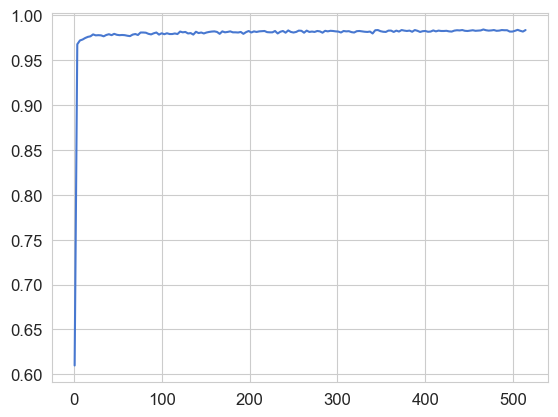

In [30]:
plt.plot(num_comp, accuracy)

In [38]:
# splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=3)

pca = PCA(n_components=10)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

y_train = torch.from_numpy(y_train).long()
y_test = torch.from_numpy(y_test).long()

dataset_train = TextDataset(torch.tensor(X_train), y_train)
dataset_test = TextDataset(torch.tensor(X_test), y_test)

# splitting the data into batches
batch_size = 64
torch.manual_seed(1)
dl_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
dl_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, drop_last=True)

# defining the model, optimizer and loss function
model = NeuralNet(input_dim=10, output_dim=5)

learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [39]:
training_model(dl_train, model, loss_fn, optimizer, num_epochs=10)

c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.951278
Epoch 2.000000      loss: 0.939631
Epoch 3.000000      loss: 0.919639
Epoch 4.000000      loss: 0.939447
Epoch 5.000000      loss: 0.939179
Epoch 6.000000      loss: 0.927068
Epoch 7.000000      loss: 0.911935
Epoch 8.000000      loss: 0.918340
Epoch 9.000000      loss: 0.907559
Epoch 10.000000      loss: 0.916645


In [40]:
predictions, labels, acc = test_loop(dl_test, model, loss_fn)

# Compute and print confusion matrix
cm = confusion_matrix(labels, predictions)
print("Confusion Matrix:")
print(cm)

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.916147 

Confusion Matrix:
[[156   0   0   1   0]
 [  2 261   0   2   0]
 [  0   0 211   0   0]
 [  1   2   0 255   1]
 [  0   0   0   1 259]]


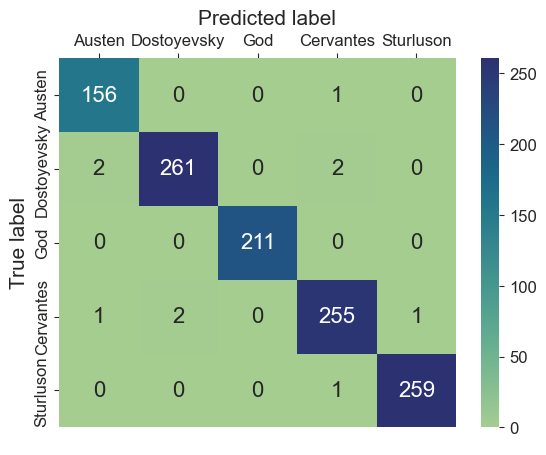

In [41]:
# plotting parameters
sns.set_style('whitegrid')
sns.set_palette('muted')
plt.rc('xtick', labelsize=12)  # Set x-tick label size
plt.rc('ytick', labelsize=12)  # Set y-tick label size

# Plotting the confusion matrix
ax = sns.heatmap(cm, 
            annot=True,
            annot_kws={"fontsize":16},
            fmt=".0f",
            xticklabels=['Austen', 'Dostoyevsky', 'God', 'Cervantes', 'Sturluson'],
            yticklabels=['Austen', 'Dostoyevsky', 'God', 'Cervantes', 'Sturluson'],
            cmap='crest')
plt.ylabel('True label', fontsize=15)
ax.set(xlabel=" ", ylabel="True label")
ax.xaxis.tick_top()
ax.yaxis.tick_left()

plt.gca().figure.text(0.45, 0.95, 'Predicted label', ha='center', fontsize=15)
plt.show()